## Reference 
https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb

In [32]:
# Import model 
img_path = 'nyanko_sensei.jpg'

from keras.models import load_model
model = load_model('binary_cat_and_dog.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

(1, 150, 150, 3)


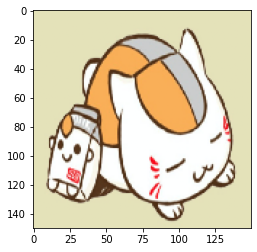

In [33]:
# Import a sample image
from keras.preprocessing import image
import numpy as np
img = image.load_img(img_path,target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor,axis=0)
img_tensor  /= 255.

print(img_tensor.shape)

import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [34]:
# List 5-27
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [35]:
# List 5-28
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


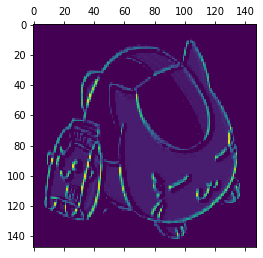

In [36]:
# List 5-29
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0,:,:,0], cmap='viridis')
plt.show()


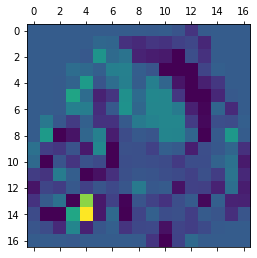

In [37]:
# List 5-30
# plt.matshow(first_layer_activation[0,:,:,27],cmap='viridis')
plt.matshow(activations[5][0,:,:,80],cmap='viridis')
plt.show()

## 5.4.1 Visualizing images on each layers

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


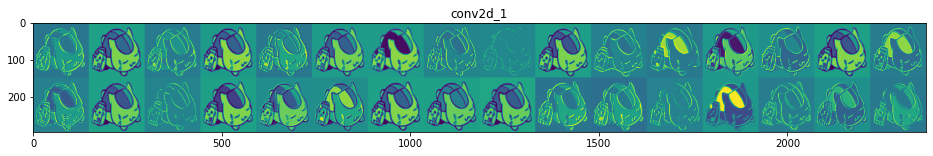

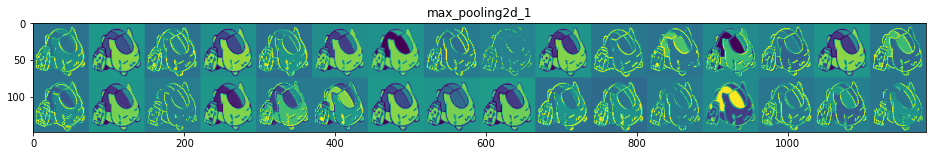

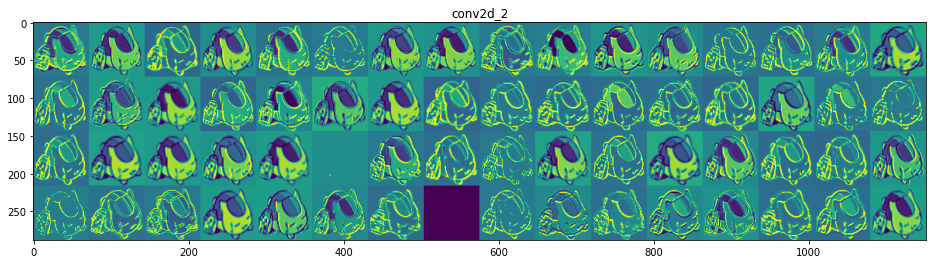

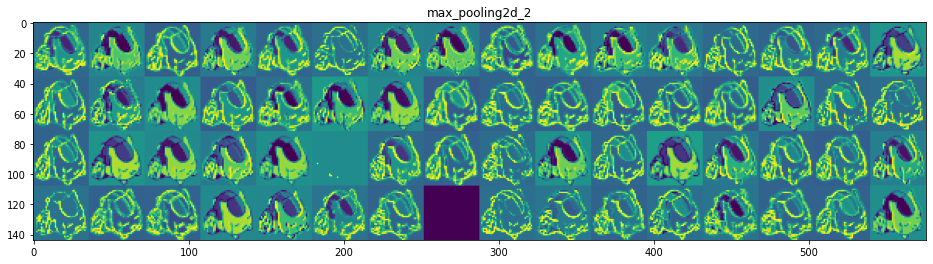

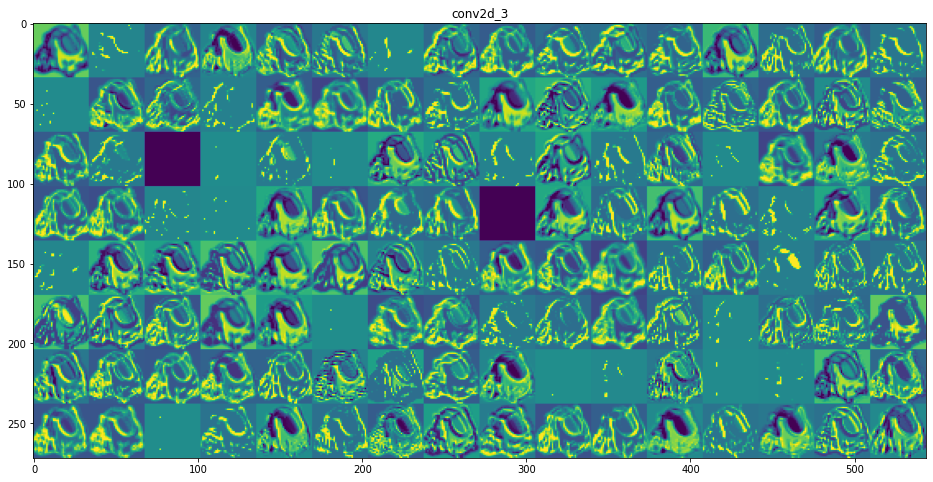

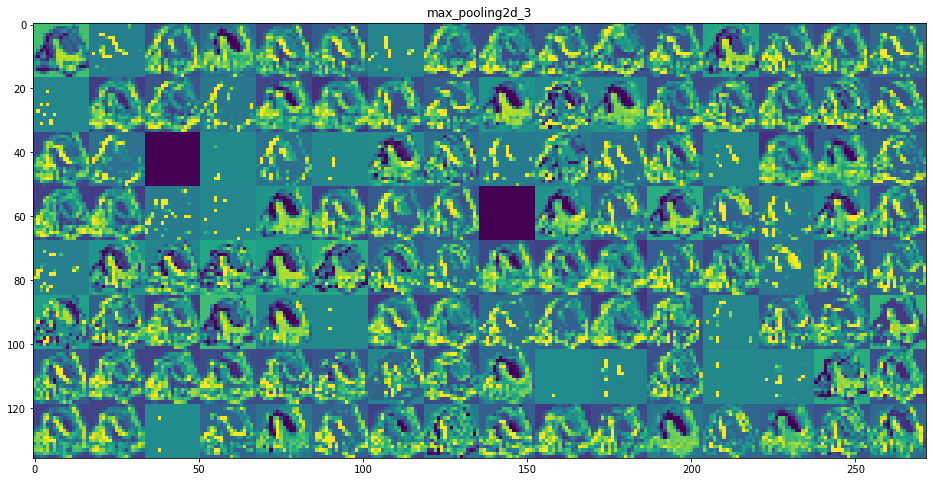

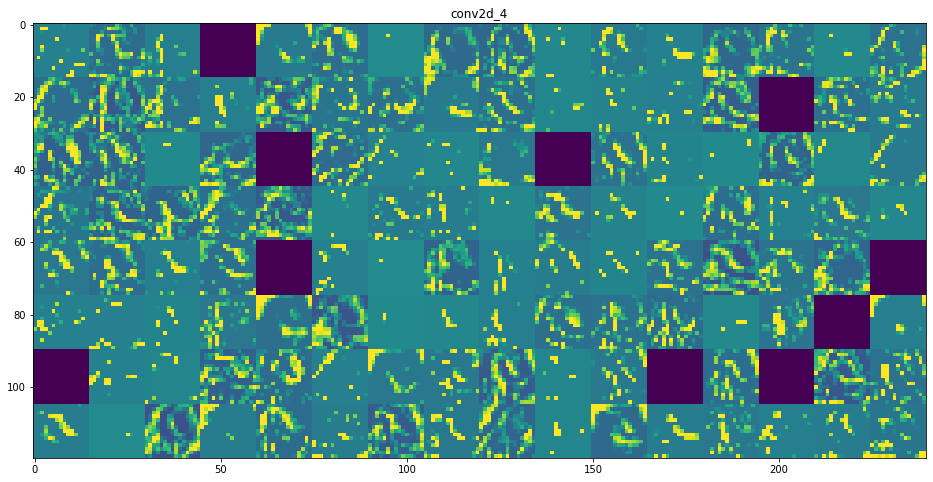

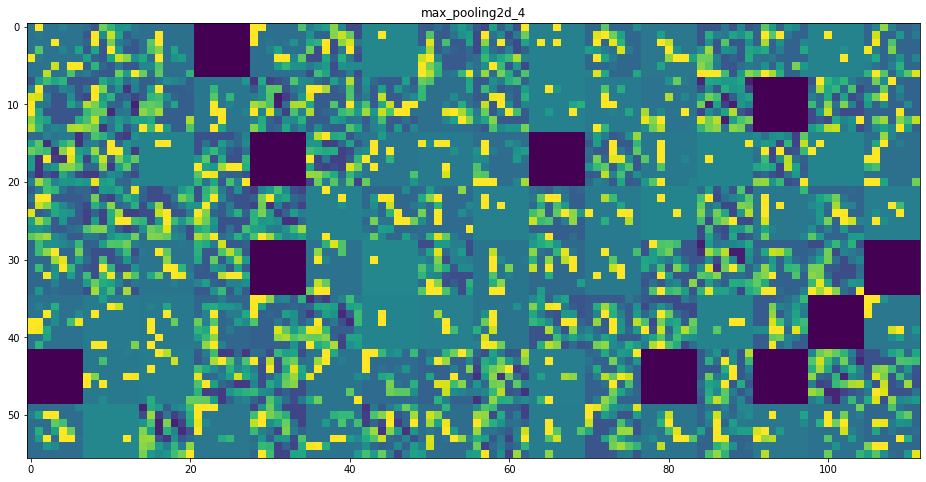

In [38]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')  

# 5.4.3 CAM(Class Activation Map)

In [39]:
# List 5-40
# Import imagenet

from keras import backend as K
from keras.applications.vgg16 import VGG16
K.clear_session()
model = VGG16(weights='imagenet')

In [40]:
# List 5-41

from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = r'nyanko_sensei.jpg'
img = image.load_img(img_path, target_size=(224,224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [41]:
preds = model.predict(x)
print('Predicted:',decode_predictions(preds,top=3)[0])


Predicted: [('n04579432', 'whistle', 0.13280694), ('n02834397', 'bib', 0.06744962), ('n02892767', 'brassiere', 0.05114576)]


In [42]:
# Max entry
np.argmax(preds[0])

902

## imagenet classs_idx to labels
https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

cf 902 = whistle

In [43]:
# List 5-42

african_elephant_output = model.output[:,386]
last_conv_layer = model.get_layer('block5_conv3')

#grads = K.gradients(african_elephant_output,last_conv_layer.output)[0]
import tensorflow as tf
g = tf.Graph()
with g.as_default():
    grads = tf.gradients(african_elephant_output,last_conv_layer.output)[0]


pooled_grads = K.mean(grads, axis =(0,1,2))

iterate = K.function([model.input],
                    [pooled_grads,last_conv_layer.output[0]])

pooled_grads_value,conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value,axis=-1)


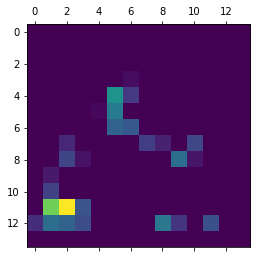

In [44]:
# List 5-43
%matplotlib inline
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

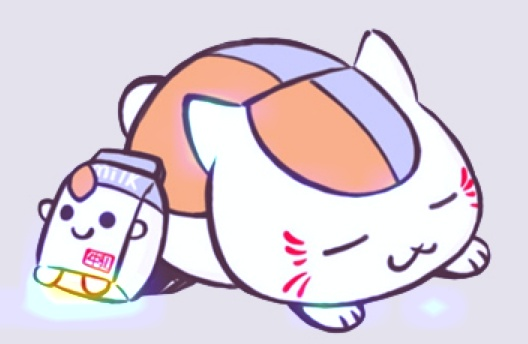

In [45]:
# List 5-44
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1],img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('heatmaped.jpg',superimposed_img)

from IPython.display import Image
Image('heatmaped.jpg')